<a href="https://colab.research.google.com/github/YazCodes/heartRatePrediction/blob/main/PredictHeartRate_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy import linalg
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
#from quantecon import Kalman, LinearStateSpace
from scipy.stats import norm
from scipy.integrate import quad
from numpy.random import multivariate_normal
from scipy.linalg import eigvals
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from numpy import dot
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Load the data 
df = pd.read_csv("PT_Train.csv")
df.head(20) #first 20 data points
df.tail() #looking at the last minutes of heartrate and where to start the prediction  

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
221,17/08/2015 18:50,159,51,NaN,NaN
222,17/08/2015 18:51,151,64,NaN,NaN
223,17/08/2015 18:52,140,64,NaN,NaN
224,17/08/2015 18:53,140,55,NaN,NaN
225,17/08/2015 18:54,138,54,NaN,NaN


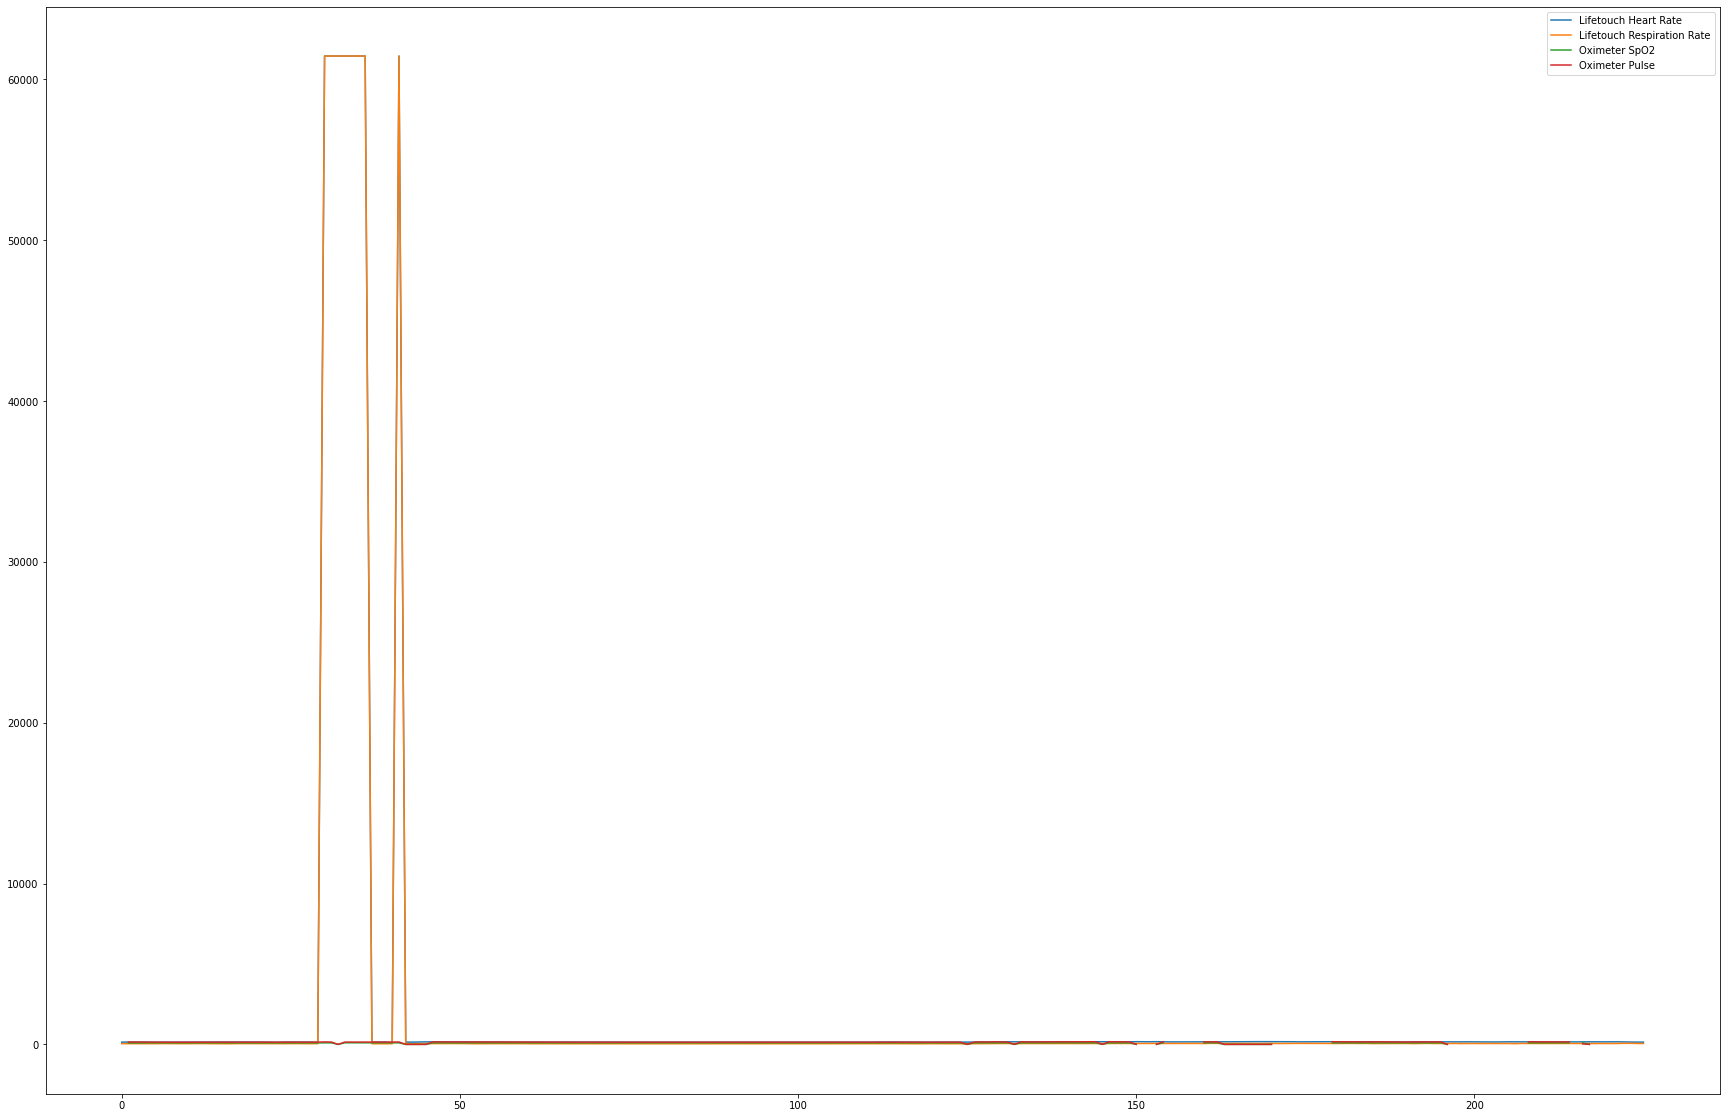

In [3]:
#Plot our data
df = pd.read_csv("PT_Train.csv")


matplotlib.rc('figure', figsize=(30, 20))
df.plot()
#This is what my date time series looks like - messy and not useful 
#Error on the Y axis range, due to the code given to the mesurements when there is bad data. values above 1000 need to be cut off 

In [ ]:
#Data cleaning 


In [4]:
#Data cleaning  - Important step as the ML model and data processing cannot start if the dataset contains missing values

df.isnull().values.any() #This shows if there are any missing values in the dataset. True = yes false = No

df = df.dropna() #drop any rows with missing values 

print(f'Number of entries: {len(df)}') #check if the number of entries have changed

Number of entries: 191


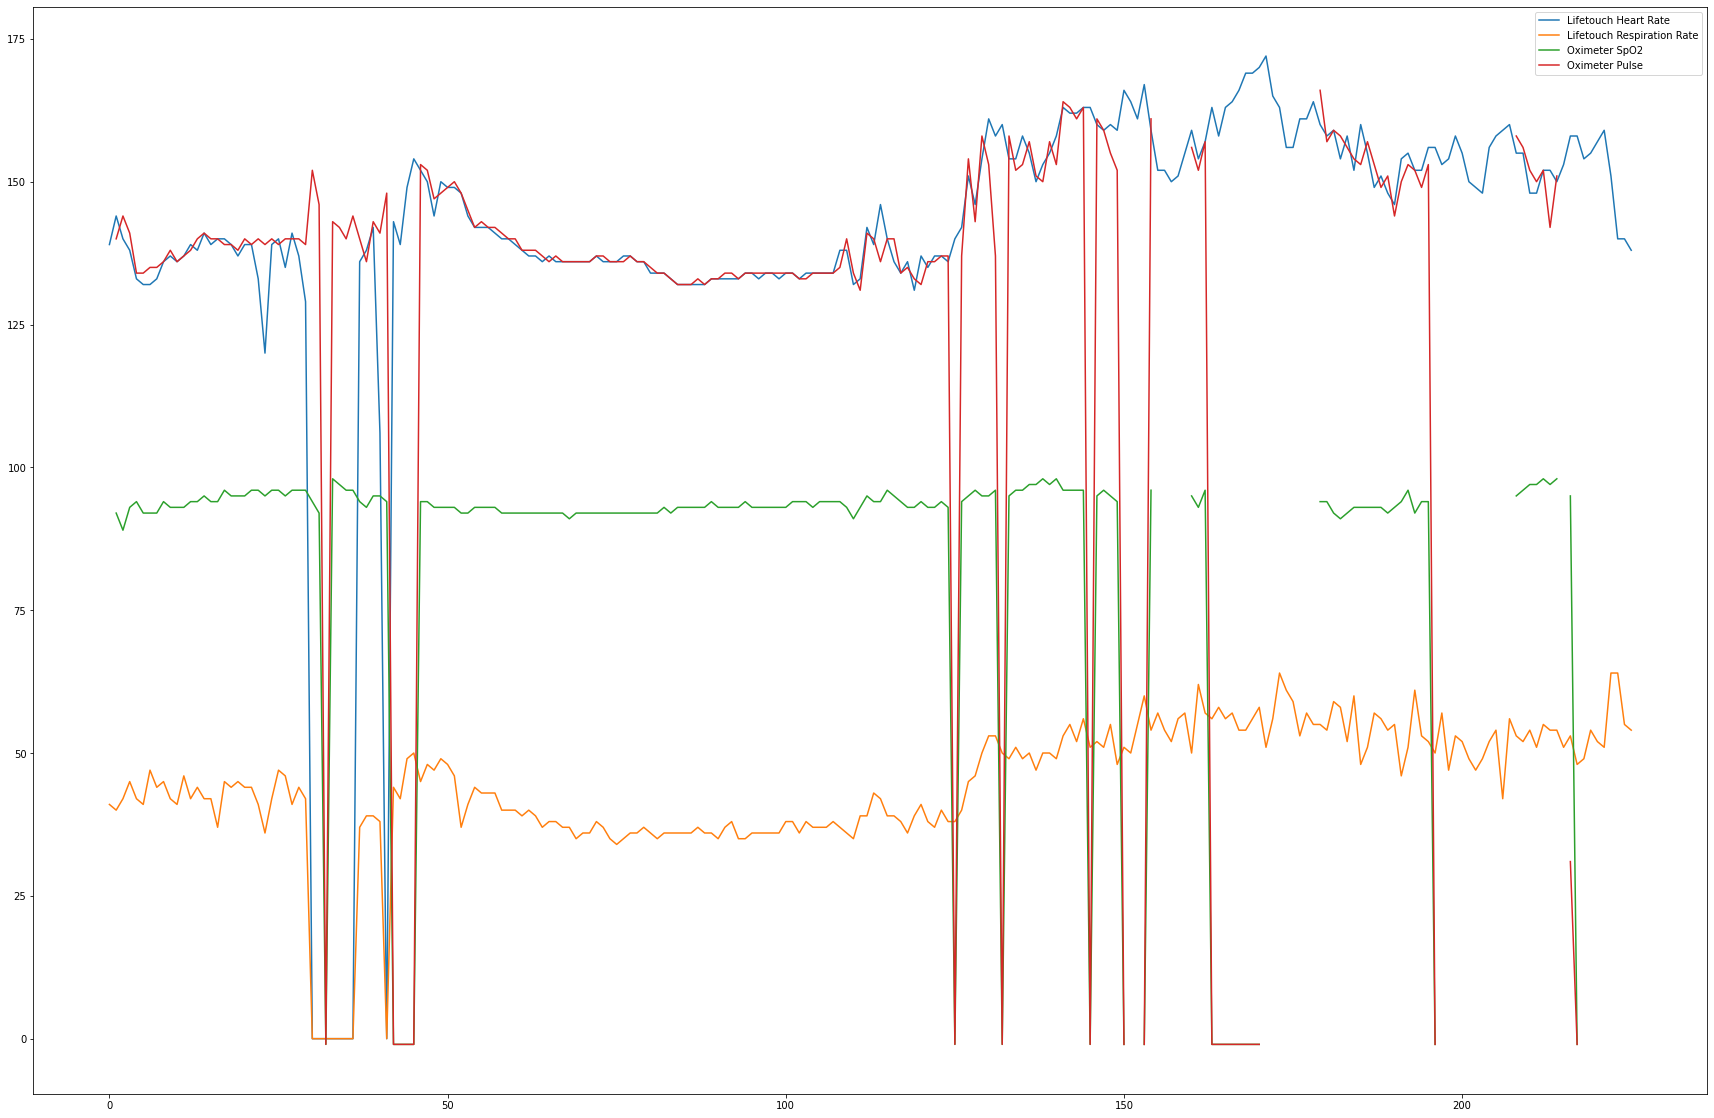

In [3]:

#Cut off function
def cutoff(row):
    vals = row
    if vals>1000:
        vals = 0  #Any value > 1000 will be set to 0 
    return vals

matplotlib.rc('figure', figsize=(30, 20))
df['Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].apply(cutoff)
df['Lifetouch Respiration Rate'] = df['Lifetouch Respiration Rate'].apply(cutoff)
df['Oximeter SpO2'] = df['Oximeter SpO2'].apply(cutoff)
df['Oximeter Pulse'] = df['Oximeter Pulse'].apply(cutoff)
#df = df.drop(labels='Timestamp (GMT)',axis=1) #drop time stamp - not needed 
df.plot()

#blue = heart rate 
#red = pulse rate 

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1671: RuntimeWarning: invalid value encountered in subtract
  resids = x - x.mean()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)



Result: The series is stationary



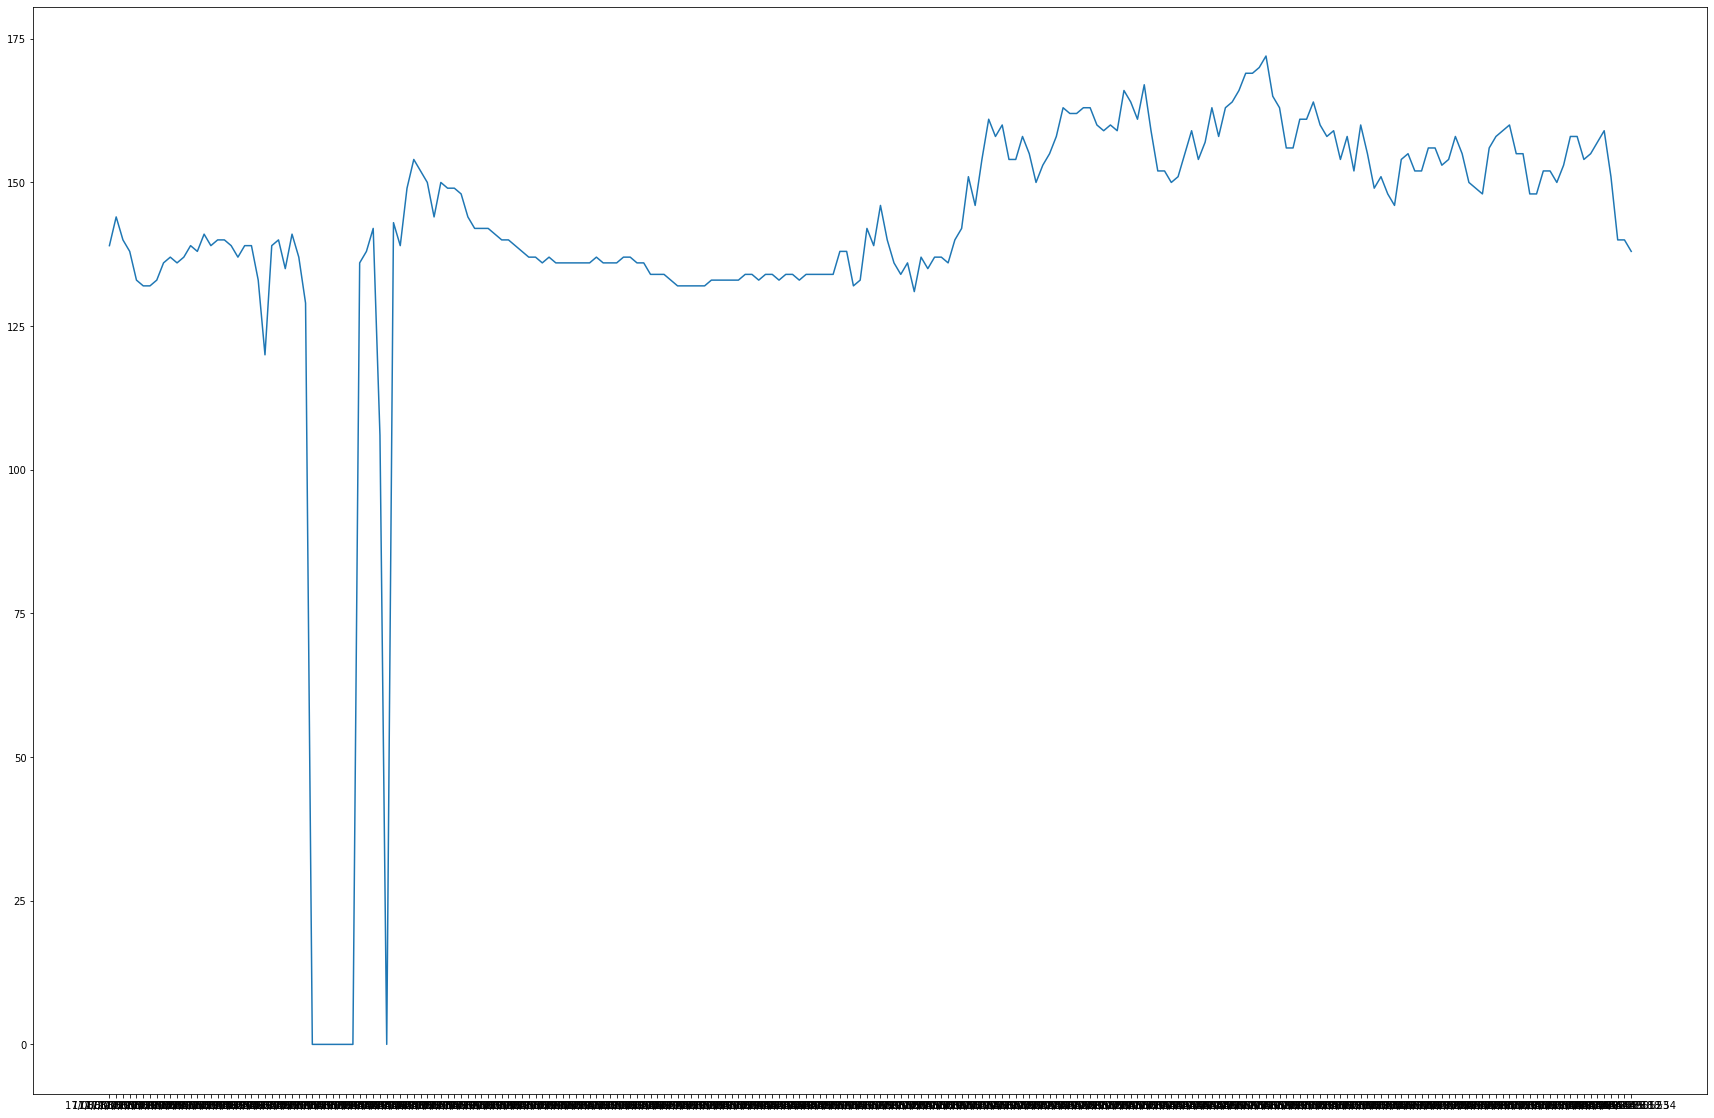

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,stationary
0,17/08/2015 15:09,139,41,NaN,NaN,4.934474
1,17/08/2015 15:10,144,40,92.0,140.0,4.969813
2,17/08/2015 15:11,140,42,89.0,144.0,4.941642
3,17/08/2015 15:12,138,45,93.0,141.0,4.927254
4,17/08/2015 15:13,133,42,94.0,134.0,4.890349


In [4]:
#Step one - check if data is stationary using the KPSS test 

df['stationary'] = np.log(df['Lifetouch Heart Rate']) # get rid of peaks and troffs using the log function, create a new column called stationary


statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(df['stationary']) 
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')

plt.plot(df['Timestamp (GMT)'],df['Lifetouch Heart Rate'])
plt.show()
df.head()


#results show data is stationary - meaning the mean, variance and covariance do not vary with time. - 

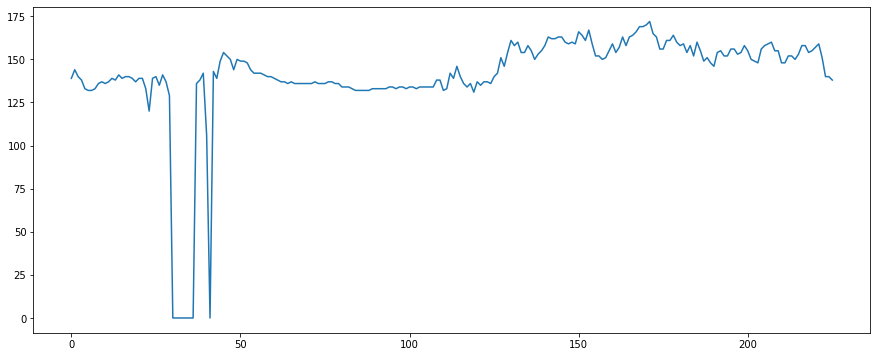

In [5]:
#ARIMA model 
 
y = df['Lifetouch Heart Rate'] #plot only the heartrate data 


y = y.fillna(y.bfill())
y.plot(figsize=(15, 6))




In [6]:
import itertools
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(0, 0, 0, 0)]  # change to 0000 - As the data is not affected by seasonality 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

#Selecting an ARIMA model order 
#Results show that this is the best result - ARIMA(2, 1, 2)x(0, 0, 0, 0)12 - AIC:1890.9735397323443 -This ARIMIA model has the lowest error rate.
#The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:2876.024007590183
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:2576.2378312954743
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:2436.246385203804
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:1928.4405694370428
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:1916.2117916317266
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:1908.1528635962297
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:2107.8374942824257
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:1919.4873409375296
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:1907.5674741338003
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:1937.2462893117417
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:1925.2824119436405
ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:1917.4050198127993
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:1924.855973073707
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:1904.9362794672556
ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:1899.2087431859675
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:2029.8894820754476
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:1916.3915571106725
ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:1900.2205663508712
ARIMA(2, 0, 0

In [8]:

# specify model - using above results 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 1, 1), #got from previous code results 
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# fit model
results = mod.fit()
print(results.summary().tables[1])
# make predictions
pred = results.get_prediction(start=pd.to_datetime('17/08/2015 18:54:00'), dynamic=False) #error?  #Where i want to start the predictions from?
pred_ci = pred.conf_int()

# plotting code
ax = y['17/08/2015 15:10:00':].plot(label='observed', figsize=(20, 15))  #where i want to start plotting the data?
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

y_forecasted = pred.predicted_mean
y_truth = y['17/08/2015 18:54:00':]  

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7453      0.048     15.505      0.000       0.651       0.839
ar.L2          0.0265      0.027      0.967      0.334      -0.027       0.080
ma.L1         -0.9735      0.040    -24.466      0.000      -1.052      -0.896
sigma2       288.7816      8.771     32.925      0.000     271.591     305.972


KeyError: ignored